In [12]:
import pandas as pd
import os
from subprocess import call
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,
                             mean_squared_log_error, median_absolute_error)
from sklearn.preprocessing import StandardScaler
from dataset_reader import get_dataset

%autoreload 2

In [13]:
# Load dataset
df = get_dataset()
df = df.drop('id', axis=1)
print(f"Dataset size: {df.shape[0]} rows")
print(f"Columns: {list(df.columns)}")

Reading profile JSONs
Filtered out 268 profiles
Labeled dataset size: 50
Dataset size: 50 rows
Columns: ['verified', 'name_len', 'followers_count', 'following_count', 'tweet_count', 'listed_count', 'has_url', 'created_at', 'desc_len', 'desc_words', 'following_followers_ratio', 'tweet.length_mean', 'tweet.words_mean', 'tweet.retweets_mean', 'tweet.replies_mean', 'tweet.likes_mean', 'tweet.quotes_mean', 'tweet.mentions_mean', 'tweet.retweets_percentage', 'credibility_score']


In [14]:
# Split dataset for test and train sets
dataset_df = df.dropna()

train_df, test_df = train_test_split(dataset_df, train_size=0.8)
y_variable = "credibility_score"
train_x = train_df.drop(y_variable, axis=1)
test_x = test_df.drop(y_variable, axis=1)
train_y = train_df[y_variable].astype(int)
test_y = test_df[y_variable].astype(int)

print(f"Training data rows: {train_df.shape[0]}")
print(f"Test data rows: {test_df.shape[0]}")

Training data rows: 40
Test data rows: 10


In [15]:
# Train model
model = RandomForestClassifier()

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

model.fit(train_x_scaled, train_y)
prediction = model.predict(test_x_scaled)

x_row = test_x_scaled[0]
dec_path = model.decision_path([x_row])
print(dec_path)

(<1x2364 sparse matrix of type '<class 'numpy.int64'>'
	with 501 stored elements in Compressed Sparse Row format>, array([   0,   35,   54,   81,  110,  135,  158,  179,  208,  231,  252,
        283,  308,  333,  356,  385,  412,  437,  458,  483,  510,  531,
        550,  575,  602,  625,  648,  673,  696,  721,  746,  761,  782,
        805,  832,  849,  868,  889,  910,  929,  946,  971, 1000, 1023,
       1054, 1077, 1094, 1117, 1138, 1165, 1190, 1213, 1240, 1267, 1294,
       1317, 1338, 1359, 1378, 1401, 1424, 1445, 1464, 1487, 1514, 1543,
       1564, 1587, 1610, 1631, 1654, 1677, 1704, 1727, 1750, 1777, 1800,
       1827, 1846, 1869, 1892, 1913, 1934, 1959, 1976, 2005, 2026, 2051,
       2076, 2101, 2130, 2149, 2172, 2199, 2224, 2247, 2268, 2295, 2314,
       2341, 2364]))


In [16]:
# Calculate errors

test_y_np = test_y.to_numpy()
test_mse = mean_squared_error(test_y_np, prediction)
test_msle = mean_squared_log_error(test_y_np, prediction)
test_mdae = median_absolute_error(test_y_np, prediction)
test_mae = mean_absolute_error(test_y_np, prediction)
test_mape = mean_absolute_percentage_error(test_y_np, prediction)
print(f"Mean squared error: {test_mse}")
print(f"Mean squared log error: {test_msle}")
print(f"Median absolute error: {test_mdae}")
print(f"Mean absolute error: {test_mae}")
print(f"Mean absolute percentage error {test_mape}")

Mean squared error: 1.2
Mean squared log error: 0.1340622975842989
Median absolute error: 1.0
Mean absolute error: 0.8
Mean absolute percentage error 0.4416666666666666


IMP:created_at                  -1.100000e-01
name_len                    -1.000000e-01
following_followers_ratio   -8.000000e-02
followers_count             -7.000000e-02
tweet.words_mean            -6.000000e-02
following_count             -2.000000e-02
verified                     0.000000e+00
tweet.quotes_mean            0.000000e+00
tweet.likes_mean             0.000000e+00
desc_words                   0.000000e+00
desc_len                     0.000000e+00
has_url                      0.000000e+00
tweet.retweets_percentage    0.000000e+00
tweet.retweets_mean          1.110223e-17
tweet_count                  1.000000e-02
tweet.mentions_mean          1.000000e-02
tweet.length_mean            2.000000e-02
tweet.replies_mean           5.000000e-02
listed_count                 5.000000e-02
dtype: float64
STD: [0.         0.06324555 0.04582576 0.04       0.07       0.06708204
 0.         0.07       0.         0.         0.06       0.07483315
 0.04898979 0.06324555 0.05       0.        

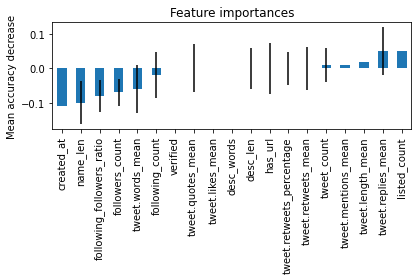

In [17]:
# Feature importances

feature_names = list(dataset_df.columns)
feature_names.remove(y_variable)

# estimator = model.estimators_[5]
# def get_feature_importances(estimator):
#     importances = []
#     for i, feature_name in enumerate(feature_names):
#         importances.append(
#             {"importance": estimator.feature_importances_[i], "feature_name": feature_name})
#     importances = sorted(importances, key=lambda x: x["importance"], reverse=True)
#     return importances

# importances = get_feature_importances(estimator)
# importance_msg = "\n".join(f"{i['feature_name']}: {i['importance']:.3f}" for i in importances)
# print(importance_msg)

from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(
    model, test_x_scaled, test_y, n_repeats=10, n_jobs=2
)
forest_importances = pd.Series(perm_imp.importances_mean, index=feature_names)
forest_importances = forest_importances.sort_values()
print("IMP:" + str(forest_importances))
print("STD: " + str(perm_imp.importances_std))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=perm_imp.importances_std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [18]:
# Save model
import pickle

# Uncomment to update saved model
#pickle.dump(model, open('model/model.pkl', 'wb'))
#pickle.dump(scaler, open('model/scaler.pkl', 'wb'))

In [19]:
# Visualize tree

estimator = model.estimators_[5]

tmp_dir = os.path.join(os.getcwd(), 'tmp')
if not os.path.isdir(tmp_dir):
    os.mkdir(tmp_dir)
graph_file = os.path.join(tmp_dir, 'tree.dot')
png_file = os.path.join(tmp_dir, 'tree.png')

export_graphviz(estimator, out_file=graph_file, feature_names=feature_names,
                class_names=None, rounded=True, proportion=False, precision=2, filled=True)

call(['dot', '-Tpng', graph_file, '-o', png_file, '-Gdpi=600'])

Image(filename=png_file)